In [81]:
import pandas as pd
pd.set_option('float_format', '{:.6f}'.format)
pd.options.mode.chained_assignment = None

from prince import MCA

import numpy as np
np.random.RandomState(seed=42)

import matplotlib.pyplot as plt

import xgboost as xgb

from os.path import isfile
import pickle
import lzma

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, scale
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import seaborn as sns

from pyclustertend import hopkins, vat

## **Импорт и обработка данных**

В предыдущей работе я провел некоторое конструирование признаков. Добавил информацию о NaN, импутировал данные.

Однако для кластеризации эта обработка не подходит ввиду наличия категориальных данных. 

Попробую применить <a href="https://en.wikipedia.org/wiki/Multiple_correspondence_analysis">Multiple Correspondence Analysis (MCA)</a>  для категориальных данных. Использую для этого библиотеку <a href=https://github.com/MaxHalford/prince#multiple-correspondence-analysis-mca>prince</a>.

In [2]:
src_df = pd.read_csv("./data/merged_df.csv", compression='xz')

Для начала выброшу TransactionID, isFraud как бесполезные.

In [3]:
work_df = src_df.drop(['TransactionID', 'isFraud', 'Unnamed: 0'], axis=1)

In [4]:
nan_columns = list(src_df.filter(regex='_nan'))

In [5]:
mca_df = work_df[nan_columns]

Категориальными предикторами являются также M5 и id_29. 

In [6]:
mca_df = mca_df.join(work_df[['M5', 'id_29']])

In [7]:
mca_worker = MCA(n_components=2, n_iter=10, copy=True, check_input=True, engine='auto', random_state=42)

In [8]:
mca_values = mca_worker.fit_transform(mca_df)

In [9]:
mca_values.describe().T

,count,mean,std,min,25%,50%,75%,max
0,144233.000000,-0.056736,0.679294,-1.057185,-0.662898,-0.317881,0.489415,1.485478
1,144233.000000,-0.083663,0.511396,-0.905093,-0.642106,-0.006409,0.149150,2.782979


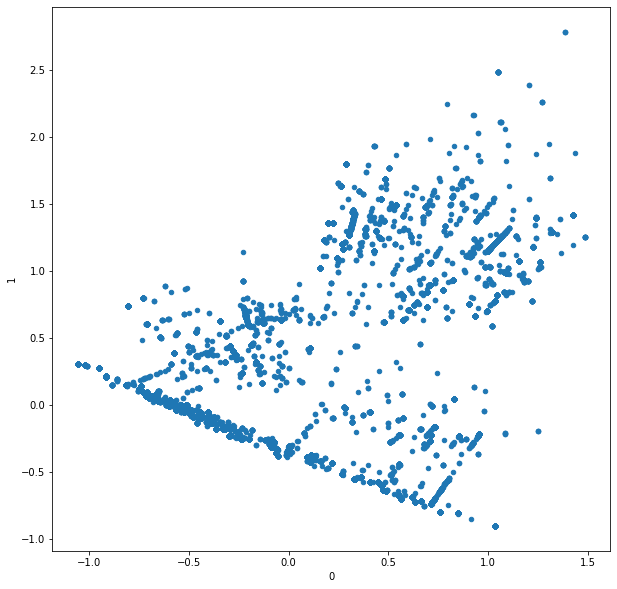

In [10]:
figure, ax = plt.subplots(figsize=(10, 10))
mca_values.plot.scatter(x=0, y=1, ax=ax)
plt.show()

Не знаю, что бы это могло значить, но выглядит вполне научно! :-)

**Эксперимент**

Интересно, а какая точность будет у классификатора на этих данных?

In [11]:
test_df = pd.DataFrame(data=mca_values.to_numpy(), columns=['MCA_1', 'MCA_2'])
test_df = test_df.join(work_df.drop(nan_columns, axis=1))
test_df = test_df.join(src_df[['isFraud']])

X = test_df.drop(['isFraud'], axis=1)
y = test_df[['isFraud']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)

over_sampler = SMOTE(random_state=42, n_jobs=-1, sampling_strategy='minority')

X_train, y_train = over_sampler.fit_resample(X_train, y_train)

dm_train = xgb.DMatrix(X_train, y_train)
dm_test = xgb.DMatrix(X_test, y_test)

xgb_01 = xgb.XGBClassifier

if isfile("./data/models/xgb_01.xz"):
    with lzma.open("./data/models/xgb_01.xz", "rb") as m_file:
        xgb_01 = pickle.load(m_file)
else:
    xgb_01 = xgb.train(
        params={
            'objective': 'binary:logistic',
            'eval_metric': 'auc'
        },
        dtrain=dm_train,
        evals=[(dm_train, "train"), (dm_test, "validation")],
        num_boost_round=10000,
        verbose_eval=20,
        early_stopping_rounds=25
    )
    
    with lzma.open("./data/models/xgb_01.xz", "wb") as m_file:
        pickle.dump(xgb_01, m_file)
        
print("ROC-AUC: {:.6f}".format(roc_auc_score(y_test, xgb_01.predict(dm_test))))
print("Accuracy: {:.6f}".format(accuracy_score(y_test, [round(x) for x in xgb_01.predict(dm_test)])))

ROC-AUC: 0.943759
Accuracy: 0.961314


Ну, по крайней мере, радикального падения точности не произошло. 

## **Кластеризация**

**Стандартизация и сборка рабочего датасета**

In [12]:
zscored_data = StandardScaler().fit_transform(work_df.drop(nan_columns, axis=1))

clust_df = pd.DataFrame(
    data=zscored_data,
    columns=work_df.drop(nan_columns, axis=1).columns.values
)

clust_df.drop(['id_29', 'M5'], axis=1, inplace=True)
clust_df = clust_df.join(pd.DataFrame(data=mca_values.to_numpy(), columns=['MCA_1', 'MCA_2']))

clust_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id_04,144233.000000,-0.000000,1.000003,-39.341701,0.083712,0.083712,0.083712,0.083712
id_20,144233.000000,-0.000000,1.000003,-2.014836,-0.911266,0.379246,0.863753,1.714698
id_24,144233.000000,0.000000,1.000003,-1.574710,-0.771115,-0.118692,0.684903,10.359866
id_33,144233.000000,-0.000000,1.000003,-1.983769,-0.914988,0.367548,0.670369,2.629800
id_22,144233.000000,0.000000,1.000003,-1.433587,-1.010588,-0.343894,1.009307,1.934556
id_02,144233.000000,-0.000000,1.000003,-1.114309,-0.678375,-0.301370,0.369431,5.176942
D4,144233.000000,0.000000,1.000003,-1.114616,-0.488223,-0.485732,-0.159479,6.070044
card1,144233.000000,0.000000,1.000003,-1.759047,-0.825341,-0.048738,1.027015,1.687325
card2,144233.000000,0.000000,1.000003,-1.816341,-0.793345,0.104896,0.959472,1.302550
card3,144233.000000,0.000000,1.000003,-3.178650,-0.601975,-0.601975,1.201697,3.572238


**Clustering tendency**

Мне стало интересно, а насколько вобще мои данные подходят для кластеризации? Оказалось, не только мне.

In [27]:
c_tendency = -1.0

if isfile("./data/models/c_tendency.xz"):
    with lzma.open("./data/models/c_tendency.xz", "rb") as m_file:
        c_tendency = pickle.load(m_file)
else:
    c_tendency = hopkins(clust_df, round(clust_df.shape[0]*.25))
    
    with lzma.open("./data/models/c_tendency.xz", "wb") as m_file:
        pickle.dump(c_tendency, m_file)

print("Clustering tendency is {:.4f}.".format(c_tendency))

Clustering tendency is 0.0172.


Нда... Данные имеют практически равномерное распределение. Пусть это будет гипотеза. Хотелось бы её опровергнуть.

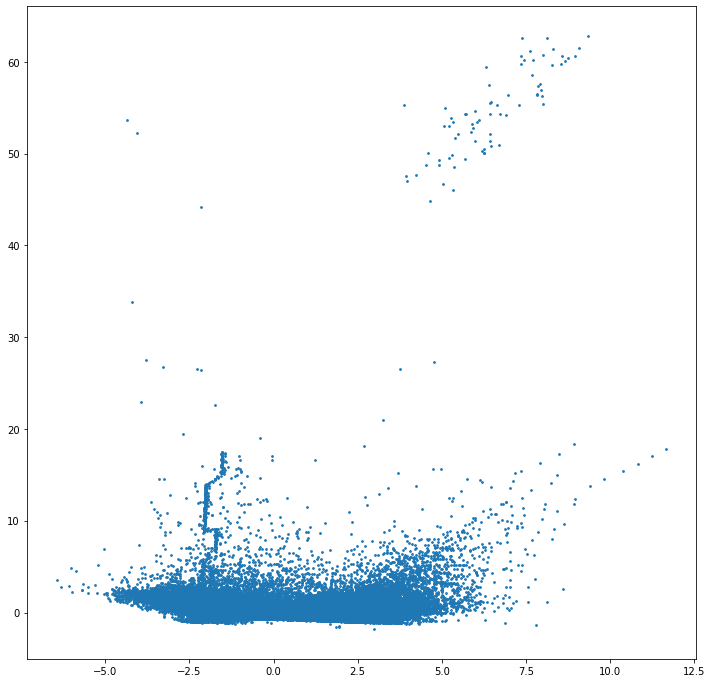

In [105]:
pca_worker = PCA(n_components=2)

clust_pca_df = pca_worker.fit_transform(clust_df)

fig = plt.figure(figsize=(12, 12))

plt.scatter(x=clust_pca_df[:, 0], y=clust_pca_df[:, 1], s=3)

plt.show()

Какбы кластеров тут не видно. То есть, кластера формироваться будут, но не очень удачно с точки зрения определения isFraud.

**Иерархическая кластеризация**

Вобщем иерархическая кластеризация не подходит для данного датасета ввиду очень большого потребления памяти для такого количества записей. 

Но попробовать интересно, поэтому сделаю downsample и посмотрю что из этого получится.

In [13]:
cluster_unsdersampled_df, cluster_undersampled_isFraud_df = RandomUnderSampler(random_state=42).fit_resample(clust_df, src_df[['isFraud']])

Нужно подобрать дистанцию. Применю для этого самый научный метод - научного тыка и чувства прекрасного.

In [14]:
distances = [1, 5, 25, 50, 100, 150, 200, 300, 500, 1000]
n_clusters = {}

if isfile("./data/models/n_clusters.xz"):
    with lzma.open("./data/models/n_clusters.xz", "rb") as m_file:
        n_clusters = pickle.load(m_file)
else:
    for distance in distances:
        cluster = AgglomerativeClustering(distance_threshold=distance, n_clusters=None).fit(cluster_unsdersampled_df)
        n_clusters[distance] = cluster.n_clusters_
    
    with lzma.open("./data/models/n_clusters.xz", "wb") as m_file:
        pickle.dump(n_clusters, m_file)

print(n_clusters)

{1: 19010, 5: 3065, 25: 171, 50: 57, 100: 20, 150: 11, 200: 7, 300: 3, 500: 1, 1000: 1}


Ну, возьму 100. И 100 и 20 числа красивые, мне так нравится.

In [15]:
h_distance = 100

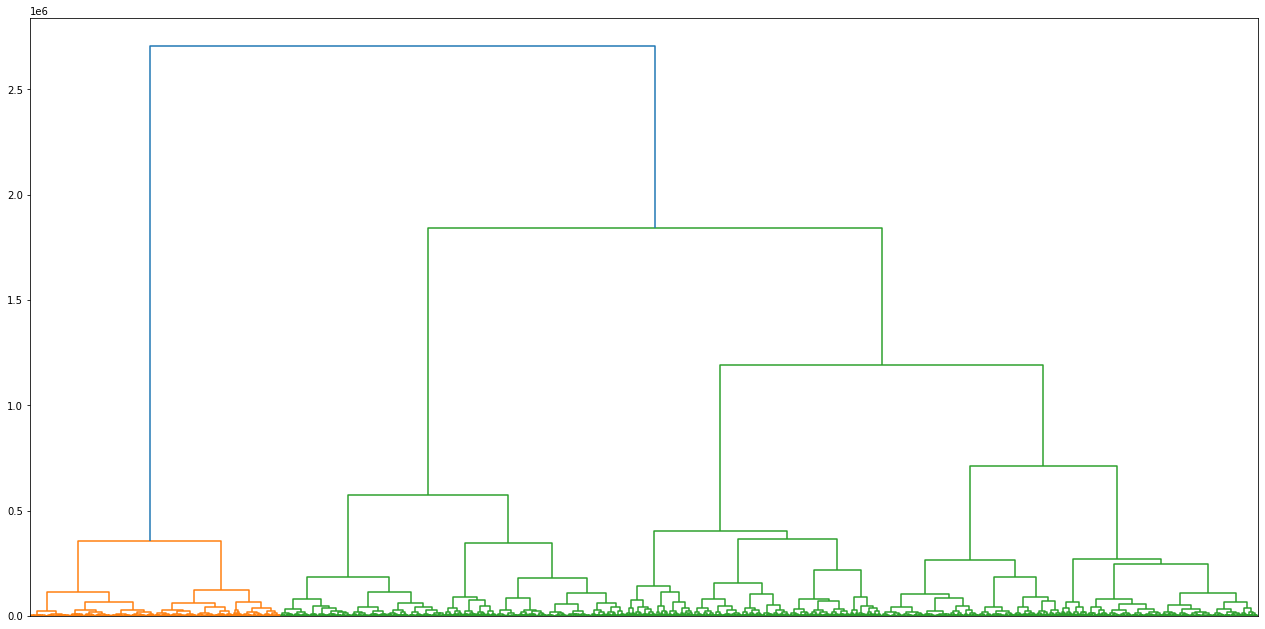

In [16]:
h_cluster = AgglomerativeClustering(distance_threshold=h_distance, n_clusters=None)

if isfile("./data/models/h_cluster.xz"):
    with lzma.open("./data/models/h_cluster.xz", "rb") as m_file:
        h_cluster = pickle.load(m_file)
else:
    h_cluster = AgglomerativeClustering(distance_threshold=h_distance, n_clusters=None).fit(cluster_unsdersampled_df)
    
    with lzma.open("./data/models/h_cluster.xz", "wb") as m_file:
        pickle.dump(h_cluster, m_file)


z = hierarchy.linkage(h_cluster.children_, 'ward')

figure, ax = plt.subplots(1, 1, figsize=(22,11))

dn = hierarchy.dendrogram(z, ax=ax, no_labels=True)

plt.show()

Проверю, как кластеры соответствуют isFraud.

In [17]:
test_df = cluster_unsdersampled_df.join(cluster_undersampled_isFraud_df)
predicted_clusters = None

if isfile("./data/models/test_df_clusters.xz"):
    with lzma.open("./data/models/test_df_clusters.xz", "rb") as m_file:
        predicted_clusters = pickle.load(m_file)
else:
    predicted_clusters = h_cluster.fit_predict(test_df)
    
    with lzma.open("./data/models/test_df_clusters.xz", "wb") as m_file:
        pickle.dump(predicted_clusters, m_file)
        
test_df['Cluster'] = predicted_clusters

In [108]:
cluster_corr = {}


for cluster in np.unique(test_df['Cluster']):
    cluster_corr[cluster] = [
        round(test_df.loc[test_df['Cluster'] == cluster].shape[0] / test_df.shape[0] * 100, ndigits=2),
        round(test_df.loc[test_df['Cluster'] == cluster]['isFraud'].isin([1]).sum() / test_df.loc[test_df['Cluster'] == cluster].shape[0] * 100, ndigits=2),
        round(test_df.loc[test_df['Cluster'] == cluster]['isFraud'].isin([1]).sum() / test_df.loc[test_df['isFraud'] == 1].shape[0] * 100, ndigits=2),
    ]

pd.DataFrame(data=cluster_corr, index=['Cluster % in DS', 'isFraud (cluster %)', 'isFraud (total isFraud %)']).T

,Cluster % in DS,isFraud (cluster %),isFraud (total isFraud %)
0,26.200000,54.000000,28.290000
1,6.160000,31.400000,3.870000
2,9.780000,78.080000,15.270000
3,1.160000,90.870000,2.110000
4,18.510000,21.000000,7.780000
5,0.180000,17.500000,0.060000
6,5.770000,80.110000,9.250000
7,0.900000,99.510000,1.790000
8,2.830000,54.220000,3.070000
9,0.930000,96.670000,1.790000
